In [1]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import ngboost as ng
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from models.flow import build_model
from tfboost.flow import ContinuousNormalizingFlow
from tfboost.tree.engboost import EmbeddableNGBoost
from tfboost.tfboost import TreeFlowBoost

In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 4*np.pi - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return (
        np.concatenate([x1, x2]),
        np.concatenate([y1, y2])
    )

In [3]:
x, y = generate_data(n=300, std=0.1)

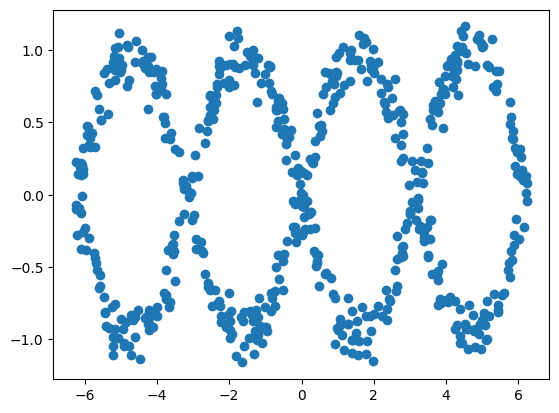

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
X_train, y_train = x.reshape(-1, 1), y
X_test, y_test = generate_data(100)
X_test = X_test.reshape(-1, 1)

In [6]:
flow = ContinuousNormalizingFlow(build_model(
    input_dim=1,
    hidden_dims=(40,40,40),
    context_dim=40,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatsquash"
))

tree = EmbeddableNGBoost()

tfb = TreeFlowBoost(flow_model=flow, tree_model = tree, embedding_size=40)

In [7]:
tfb.fit(X_train, y_train, n_epochs=200)

[iter 0] loss=1.0718 val_loss=0.0000 scale=2.0000 norm=1.5127
[iter 100] loss=0.9477 val_loss=0.0000 scale=2.0000 norm=1.3957
[iter 200] loss=0.8581 val_loss=0.0000 scale=2.0000 norm=1.3246
[iter 300] loss=0.7699 val_loss=0.0000 scale=2.0000 norm=1.2613
[iter 400] loss=0.7142 val_loss=0.0000 scale=1.0000 norm=0.6130


-1.029396891593933: 100%|██████████| 200/200 [01:45<00:00,  1.90it/s]   


TreeFlowBoost(embedding_size=40,
              flow_model=<tfboost.flow.ContinuousNormalizingFlow object at 0x7f05d955ca90>,
              tree_model=<tfboost.tree.engboost.EmbeddableNGBoost object at 0x7f05d955c690>)

In [8]:
samples = tfb.sample(X_train, num_samples=50)

In [9]:
y_hat = tfb.predict(X_train, num_samples=50)

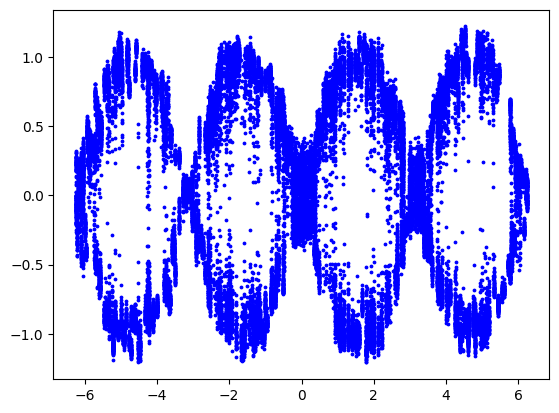

In [12]:
for i in range(samples.shape[1]):
    plt.scatter(X_train, samples[:, i], s=3, c='b')

    
# plt.scatter(X_train, y_hat, s=3, c='r')
plt.show()